In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model
from keras import optimizers
from keras import backend as K
from random import randint
import random
import pickle
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from datetime import datetime
from scipy.stats import ortho_group
from string import ascii_uppercase as letters
%matplotlib inline

Using TensorFlow backend.


# Define Model

In [3]:
# This function recompiles model for for each training instance
# n: Number of hidden layers
# activation: String denoting the activation function for hidden layers 
# initializer: keras.initializers object used for initializing weights
# optimizer: keras.optimizers object used during training
def create_model(n, activation, initializer, optimizer):
    model = Sequential()
    model.add(Dense(units=256, 
                    activation=activation,
                    kernel_initializer=initializer,
                    bias_initializer=initializer,
                    input_dim=52))
    for j in range(n):
        model.add(Dense(units=256,
                        activation=activation,
                        kernel_initializer=initializer,
                        bias_initializer=initializer))
    model.add(Dense(units=1, 
                    activation='sigmoid',
                    kernel_initializer=initializer,
                    bias_initializer=initializer))
    
    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    return model

# Define Encodings

In [4]:
# Define binary distributed enoding (j active bits)
def get_distr_j_encoding(k=26, j=2):
    array_dict = {}
    str_dict = {}
    for i,letter in enumerate(letters):
        indexes = np.random.choice(a=k, size=j, replace=False)
        encoding = np.array([1 if i in indexes else 0 for i in range(k)])
        encoding_str = ''.join(str(b) for b in encoding)
        while encoding_str in str_dict.values():
            indexes = np.random.choice(a=k, size=j, replace=False)
            encoding = np.array([1 if i in indexes else 0 for i in range(k)])
            encoding_str = ''.join(str(b) for b in encoding)
        array_dict[letter] = encoding
        str_dict[letter] = encoding_str
    return array_dict, str_dict
        
# Define normal encoding
def get_normal_encoding(k=26):
    array_dict = {}
    str_dict = {}
    matrix = np.random.normal(loc=0,size=(k,k)) / (k**0.5)
    for i,row in enumerate(matrix):
        encoding_str = ''.join(str(b) for b in row)
        array_dict[letters[i]] = row
        str_dict[letters[i]] = encoding_str
    return array_dict, str_dict

# Define one hot encoding
def get_one_hot_encoding(k=26):
    array_dict = {}
    str_dict = {}
    for i,letter in enumerate(letters):
        encoding = np.zeros(k)
        encoding[i] = 1
        encoding_str = ''.join(str(int(b)) for b in encoding)
        
        array_dict[letter] = encoding
        str_dict[letter] = encoding_str
    return array_dict, str_dict

# Define the distributed encoding
def get_distr_encoding(k=26):
    array_dict = {}
    str_dict = {}
    for i,letter in enumerate(letters):
        encoding = np.random.randint(0,2,k)
        encoding_str = ''.join(str(b) for b in encoding)
        while encoding_str in str_dict.values():
            encoding = np.random.randint(0,2,k)
            encoding_str = ''.join(str(b) for b in encoding)
        array_dict[letter] = encoding
        str_dict[letter] = encoding_str
    return array_dict, str_dict

# Define Haar encoding
def get_orthogonal_encoding(k=26):
    matrix = ortho_group.rvs(dim=k)
    array_dict = {}
    str_dict = {}
    for i,row in enumerate(matrix):
        array_dict[letters[i]] = row
        str_dict[letters[i]] = ''.join(str(c) for c in row)
    return array_dict, str_dict

# Define Train and Test Set Words

In [ ]:
# Creates encoded words
def create_encoded_words(encoding, words):
    x_test_list = [np.append(encoding[w[0]],encoding[w[1]]) for w in words]
    return np.array(x_test_list)

# Creates test set words
def create_test_words():                
    words = ['AA','AB']
    for x in letters[24:26]:
        for y in letters[24:26]:
            words.append(x + y)

    words.append(letters[randint(0,23)] + 'Y')
    words.append(letters[randint(0,23)] + 'Z')
    return words

# Create x_train and y_train from the encoding
def create_train_words():
    good_words = np.array([i + i for i in letters[:24]])
    bad_words = np.array([x + y for x in letters[:24] for y in letters[:24] if x!=y])
    
    x_train = good_words
    x_train = np.append(x_train, np.random.choice(bad_words,48,replace=False))
    y_train = np.append(np.ones(24), np.zeros(48))
    
    return x_train, y_train

# Define Experiments

In [10]:
# This function runs the experiments and saves both the training histories and test set results
# test_words: List of test words (each word as a string)
# encoding_f: Function object for creating encodings
# filename: Filename for saving
# n_epochs: Number of epochs to train
# layer_range: Generator for range of hidden layers to test (default 1 through 3)
# n_experiments: Number of experiments for each network architecture (default 40)
# seed: Random seed (default 1)
def run(test_words, encoding_f, filename, n_epochs,
        layer_range=range(3), n_experiments=40, seed=1):
    # Fit models and create dataframes
    df_list = []
    
    test_labels = test_words.copy()
    test_labels[1] = 'xy'

    # Start main loop
    for i in layer_range:
        random.seed(seed)
        history_list = []
        df = pd.DataFrame(columns=test_labels)
        for j in range(n_experiments):
            K.clear_session()
            # Create x_train words
            train_words,y_train = create_train_words()
            
            encoding, str_encoding = encoding_f()
            x_test = create_encoded_words(encoding, test_words)
            x_train = create_encoded_words(encoding, train_words)

            # Add bad word to test set (depending on x_train)
            x_test[1] = x_train[np.where(y_train == 0)[0][0]]
            y_test = np.array([1,0,1,0,0,1,0,0])

            optimizer = keras.optimizers.Adam()
            initializer = keras.initializers.RandomNormal(mean=0)

            model = create_model(i,'relu', initializer=initializer, optimizer=optimizer)
            history = model.fit(x_train, y_train, 
                                epochs=n_epochs, batch_size=72, verbose=0, shuffle=True, 
                                validation_data=(x_test,y_test))
            history_list.append(history.history)
            df = df.append(pd.DataFrame(model.predict(x_test).T, columns=test_labels), ignore_index=True)

        save_dict = {}
        save_dict['df_list'] = df
        save_dict['history_list'] = history_list

        with open(filename.format(i+1), 'wb') as f:
            pickle.dump(save_dict, f)

# Run Experiments

In [11]:
run_list = [
    {'encoding':get_one_hot_encoding, 'n_epochs':100, 'filename':'runs/one_hot/100it_run{}.pkl'},
    {'encoding':get_one_hot_encoding, 'n_epochs':500, 'filename':'runs/one_hot/500it_run{}.pkl'},
    {'encoding':get_distr_encoding, 'n_epochs':100, 'filename':'runs/binary/100it_run{}.pkl'},
    {'encoding':get_distr_encoding, 'n_epochs':500, 'filename':'runs/binary/500it_run{}.pkl'},
    {'encoding':get_normal_encoding, 'n_epochs':100, 'filename':'runs/normal/100it_run{}.pkl'},
    {'encoding':get_normal_encoding, 'n_epochs':500, 'filename':'runs/normal/500it_run{}.pkl'},
    {'encoding':get_orthogonal_encoding, 'n_epochs':100, 'filename':'runs/haar/100it_run{}.pkl'},
    {'encoding':get_orthogonal_encoding, 'n_epochs':500, 'filename':'runs/haar/500it_run{}.pkl'},
    {'encoding':get_distr_j_encoding, 'n_epochs':100, 'filename':'runs/binary_3/100it_run{}.pkl'},
    {'encoding':get_distr_j_encoding, 'n_epochs':500, 'filename':'runs/binary_3/500it_run{}.pkl'},
    {'encoding':get_distr_j_encoding, 'n_epochs':100, 'filename':'runs/binary_2/100it_run{}.pkl'},
    {'encoding':get_distr_j_encoding, 'n_epochs':500, 'filename':'runs/binary_2/500it_run{}.pkl'}
]

# Create x_test words
test_words = create_test_words()

for run_dict in run_list:
    run(test_words, encoding_f=run_dict['encoding'], 
        filename=run_dict['filename'], n_epochs=run_dict['n_epochs'], seed=1)

# Show Results

In [2]:
# Returns runs from results folder
def get_runs(filename, runs_range):
    runs = []
    for i in runs_range:
        with open(filename.format(i), 'rb') as f:
            runs.append(pickle.load(f))
    return runs  

In [3]:
run1 = get_runs('runs/one_hot/500it_run{}.pkl', range(1,4))

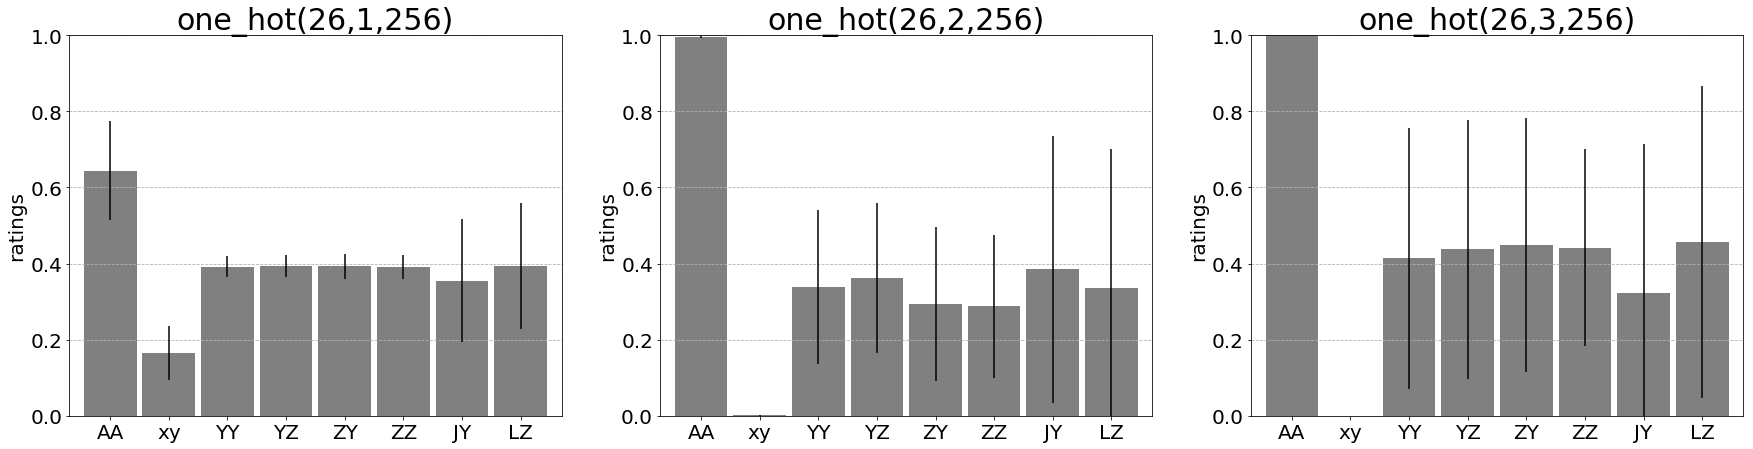

In [7]:
fig,ax = plt.subplots(1,3,figsize=(30,7))
plt.setp(ax, ylim=(0,1))

for i,run in enumerate(run1):
    df = run['df_list'].T
    df['mean'] = df.mean(axis=1)
    df['std'] = df.std(axis=1)
    df['mean'].plot(kind='bar',width=0.9, color='grey', ax=ax[i], yerr=df['std'])

    ax[i].set_title(f'one_hot(26,{i+1},256)', fontsize=30)
    ax[i].set_ylabel('ratings',fontsize=20)
    ax[i].tick_params(labelsize=20,rotation=0)
    ax[i].grid(axis='y',linestyle='--')
    
plt.savefig('one_hot_box.png', bbox_inches='tight')    
plt.show()

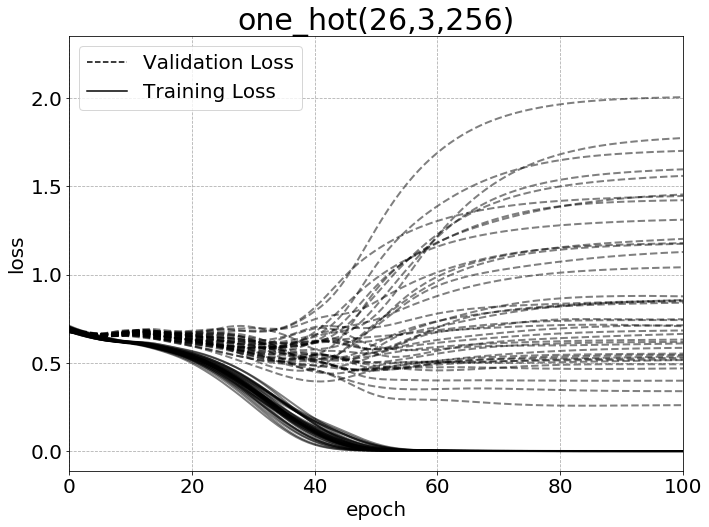

In [6]:
fig,ax = plt.subplots(figsize=(11,8))

for history in run1[2]['history_list']:
    plt.plot(history['val_loss'], linestyle='dashed', color='black', alpha=0.5, linewidth=2, label='Validation Loss')
    plt.plot(history['loss'], linestyle='solid', color='black', alpha=0.5, linewidth=2, label='Training Loss')
    plt.xlim(0,100)
    ax.grid(linestyle='--')
    
    ax.set_title('one_hot(26,3,256)', fontsize=30)
    ax.set_ylabel('loss', fontsize=20)
    ax.set_xlabel('epoch', fontsize=20)
    ax.tick_params(labelsize=20)
    
    val_loss = mlines.Line2D([], [], color='black', linestyle='--', label='Validation Loss')
    train_loss = mlines.Line2D([], [], color='black', linestyle='solid', label='Training Loss')
    plt.legend(handles=[val_loss,train_loss], loc='upper left', fontsize=20)
    
plt.savefig('one_hot_loss_log.png', bbox_inches='tight') 
plt.show()

In [7]:
run2 = get_runs('runs/haar/500it_run{}.pkl', range(1,4))

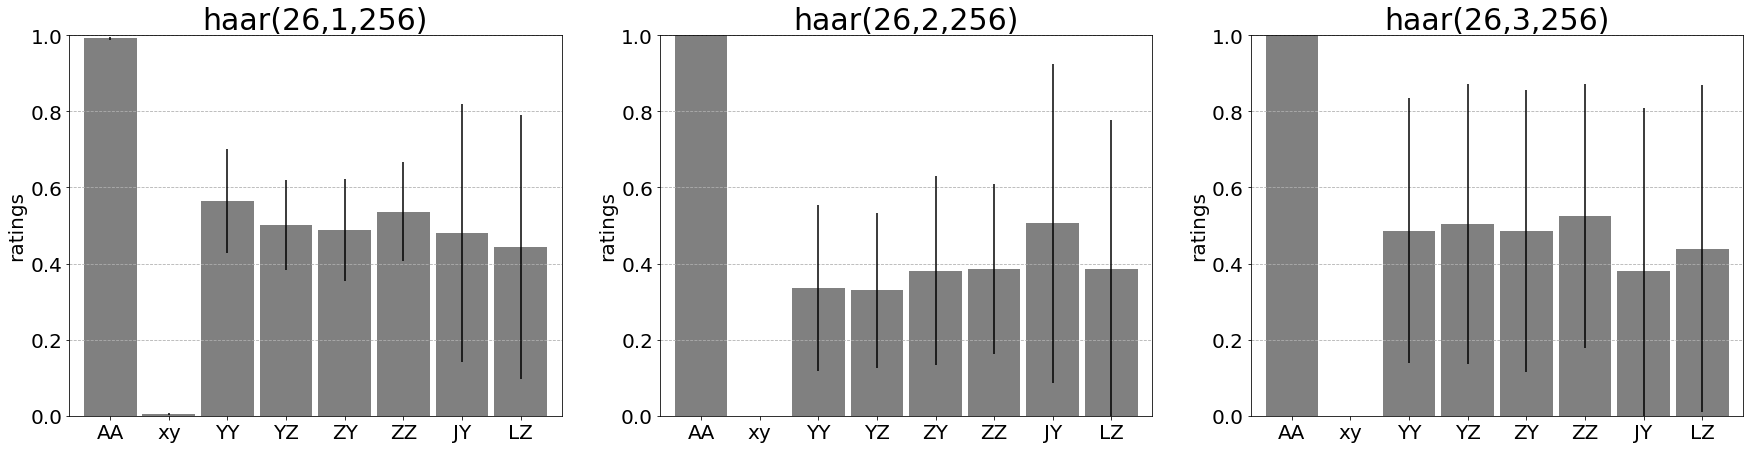

In [10]:
fig,ax = plt.subplots(1,3,figsize=(30,7))
plt.setp(ax, ylim=(0,1))

for i,run in enumerate(run2):
    df = run['df_list'].T
    df['mean'] = df.mean(axis=1)
    df['std'] = df.std(axis=1)
    df['mean'].plot(kind='bar',width=0.9, color='grey', ax=ax[i], yerr=df['std'])

    ax[i].set_title(f'haar(26,{i+1},256)', fontsize=30)
    ax[i].set_ylabel('ratings',fontsize=20)
    ax[i].tick_params(labelsize=20,rotation=0)
    ax[i].grid(axis='y',linestyle='--')

plt.savefig('haar_box.png', bbox_inches='tight')
plt.show()

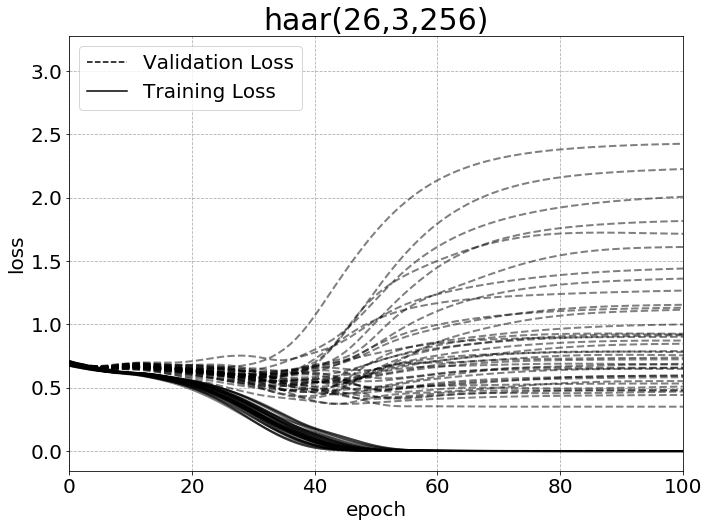

In [8]:
fig,ax = plt.subplots(figsize=(11,8))

for history in run2[2]['history_list']:
    plt.plot(history['val_loss'], linestyle='dashed', color='black', alpha=0.5, linewidth=2, label='Validation Loss')
    plt.plot(history['loss'], linestyle='solid', color='black', alpha=0.5, linewidth=2, label='Training Loss')
    plt.xlim(0,100)
    ax.grid(linestyle='--')
    
    ax.set_title('haar(26,3,256)', fontsize=30)
    ax.set_ylabel('loss', fontsize=20)
    ax.set_xlabel('epoch', fontsize=20)
    ax.tick_params(labelsize=20)
    
    val_loss = mlines.Line2D([], [], color='black', linestyle='--', label='Validation Loss')
    train_loss = mlines.Line2D([], [], color='black', linestyle='solid', label='Training Loss')
    plt.legend(handles=[val_loss,train_loss], loc='upper left', fontsize=20)
    
plt.savefig('haar_loss_log.png', bbox_inches='tight')
plt.show()

In [9]:
run3 = get_runs('runs/binary_3/500it_run{}.pkl', range(1,4))

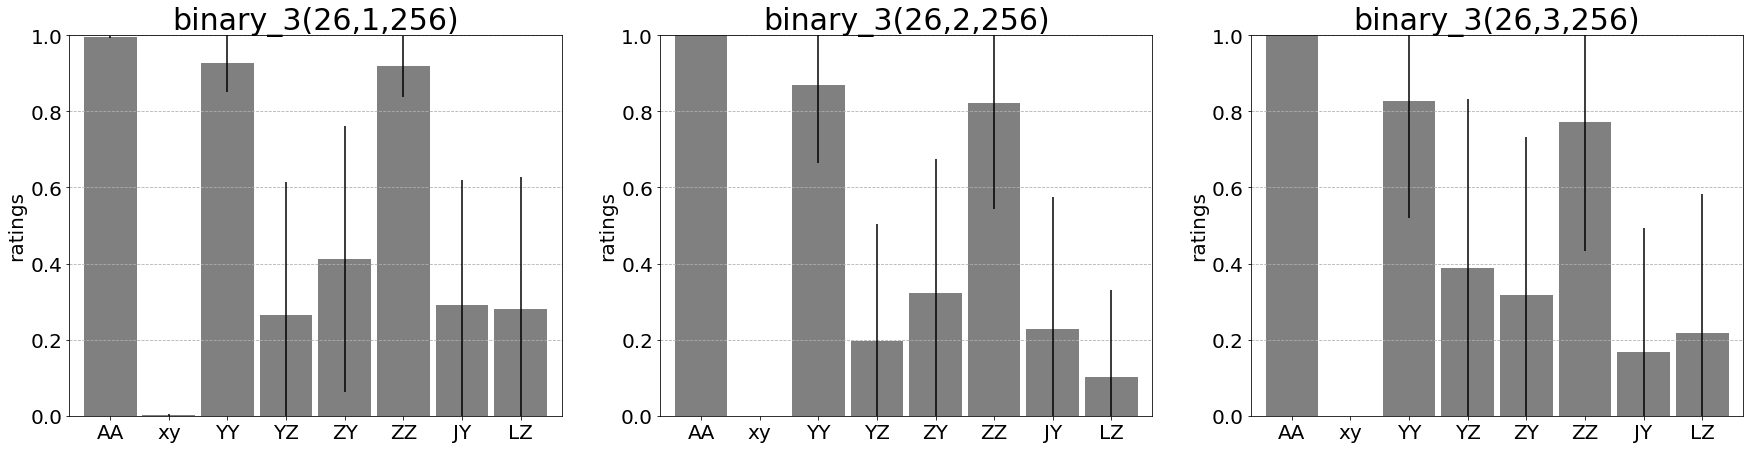

In [13]:
fig,ax = plt.subplots(1,3,figsize=(30,7))
plt.setp(ax, ylim=(0,1))

for i,run in enumerate(run3):
    df = run['df_list'].T
    df['mean'] = df.mean(axis=1)
    df['std'] = df.std(axis=1)
    df['mean'].plot(kind='bar',width=0.9, color='grey', ax=ax[i], yerr=df['std'])

    ax[i].set_title(f'binary_3(26,{i+1},256)', fontsize=30)
    ax[i].set_ylabel('ratings',fontsize=20)
    ax[i].tick_params(labelsize=20,rotation=0)
    ax[i].grid(axis='y',linestyle='--')

plt.savefig('binary_3_box.png', bbox_inches='tight') 
plt.show()

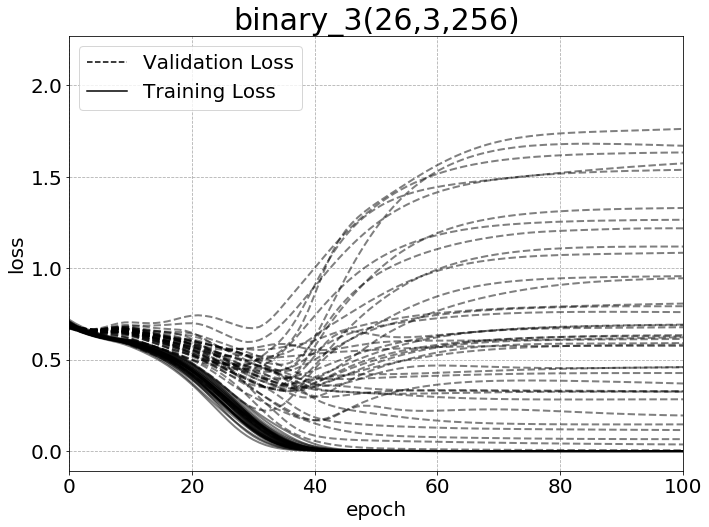

In [10]:
fig,ax = plt.subplots(figsize=(11,8))

for history in run3[2]['history_list']:
    plt.plot(history['val_loss'], linestyle='dashed', color='black', alpha=0.5, linewidth=2, label='Validation Loss')
    plt.plot(history['loss'], linestyle='solid', color='black', alpha=0.5, linewidth=2, label='Training Loss')
    plt.xlim(0,100)
    ax.grid(linestyle='--')
    
    ax.set_title('binary_3(26,3,256)', fontsize=30)
    ax.set_ylabel('loss', fontsize=20)
    ax.set_xlabel('epoch', fontsize=20)
    ax.tick_params(labelsize=20)
    
    val_loss = mlines.Line2D([], [], color='black', linestyle='--', label='Validation Loss')
    train_loss = mlines.Line2D([], [], color='black', linestyle='solid', label='Training Loss')
    plt.legend(handles=[val_loss,train_loss], loc='upper left', fontsize=20)

plt.savefig('binary_3_loss_log.png', bbox_inches='tight')    
plt.show()